In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import glob
import geopandas
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from shapely import geometry
from datetime import datetime

## Model Training

In [2]:
combined_gdf_clean_dup_removed = geopandas.read_file('../../data/interim/multisat_grid_apr_sep_2019_clean.geojson')
#combined_gdf_clean_dup_removed = geopandas.read_file('../../data/interim/multisat_grid_500m_buffer_apr_sep_2019_clean.geojson')

In [3]:
combined_gdf_clean_dup_removed.drop(columns=['end_date', 'start_date', 'period'], inplace=True)

In [4]:
combined_gdf_clean_dup_removed.loc[combined_gdf_clean_dup_removed['truth_flag'] == -1, 'truth_flag'] = 1

In [5]:
#assign weight of hotspot grid to be 0 for missed detections
#combined_gdf_clean_dup_removed.loc[combined_gdf_clean_dup_removed.id_grid.isna(), ['polar_weight', 'geo_weight', 'weight']] = 0

### Method 1: Feature engineering 
For each grid, we will now create a new feature called **weight** $W$
$$
W = (1 - \alpha) w_g + \alpha w_p
$$
where $w_g$ is the combined normalised weight/probability of geostationary satellite, while $w_p$ is the combined normalised weight/probability of polar orbiting satellite.

Note that $W$ may be greater than 1 due to contribution from overlapping hotspots.

If $\alpha$ = 0, it means that no polar-orbiting satellite data is considered. 

If $\alpha$ = 1, it means that no geostationary satellite data is considered.

We will iterate through different combinations of $\alpha$ from $[0, 1]$

In [6]:
import numpy as np
alpha_list = np.linspace(0, 1.0, 11)
alpha_score_df = pd.DataFrame({'alpha':alpha_list})
alpha_score_df

,alpha
0,0.0
1,0.1
2,0.2
3,0.3
4,0.4
5,0.5
6,0.6
7,0.7
8,0.8
9,0.9


In [7]:
predict_gdf = combined_gdf_clean_dup_removed[['polar_weight', 'geo_weight', 'truth_flag']]
predict_gdf.reset_index(inplace=True,drop=True)
predict_gdf.head()

,polar_weight,geo_weight,truth_flag
0,0.1600,0.000000,1.0
1,0.4000,0.000000,1.0
2,0.5675,0.087519,1.0
3,0.7550,0.128630,1.0
4,0.2500,0.000000,1.0


In [8]:
predict_features =['polar_weight', 'geo_weight']

In [9]:
#for training purpose, we remove the missed detections
predict_gdf_no_FN = predict_gdf.dropna(subset=predict_features)

In [10]:
print (f'Percentage of Missed Detections : {(len(predict_gdf)-len(predict_gdf_no_FN))/len(predict_gdf) * 100}%')

Percentage of Missed Detections : 6.688390404484135%


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

training_df, test_df = train_test_split(predict_gdf_no_FN[[*predict_features, 'truth_flag']], test_size=0.2, random_state=123, shuffle=True)

training_minority_df = training_df[(training_df['truth_flag'] == 1)]
training_majority_df = training_df[(training_df['truth_flag'] == 0)]

training_downsampled_df = resample(training_majority_df, replace=False, 
                                   n_samples=len(training_minority_df), random_state=123)

training_balanced_df = pd.concat([training_downsampled_df, training_minority_df])

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, brier_score_loss
from sklearn.metrics import roc_curve

In [18]:
#Setup the grid search params and model choices
model_param_json = {
    'LR': {
        'clf': LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr'),
        'param_grid': [
            { 'clf__C': [0.5, 1.0, 1.5, 2.5],
             'clf__penalty': ['none', 'l1', 'l2'],
             'clf__fit_intercept': [True],
            'clf__solver': ['saga']},
        ]
    }
}

For method 1, we only need to use a simple Logistic Regression model as only 1 feature $W$ is used for prediction.

In [19]:
model = 'LR'
for index, row in alpha_score_df.iterrows():
    alpha = row['alpha']
    
    #only use LR in this case since only 1 feature is involved
    clf_pipeline = Pipeline([('clf', model_param_json[model]['clf'])])    
    
    gs_clf = GridSearchCV(estimator=clf_pipeline, 
                           param_grid=model_param_json[model]['param_grid'], 
                           scoring='roc_auc', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=3, 
                           refit=True,
                           pre_dispatch='2*n_jobs')
    
    training_balanced_df['weight'] = ((1 - alpha) * training_balanced_df['geo_weight']) + (alpha * training_balanced_df['polar_weight']) 
    test_df['weight'] = ((1 - alpha) * test_df['geo_weight']) + (alpha * test_df['polar_weight']) 
    
    X_train = training_balanced_df['weight'].values.astype(float).reshape(-1, 1)
    x_test = test_df['weight'].values.astype(float).reshape(-1, 1)
    
    gs_clf.fit(X_train, training_balanced_df['truth_flag'])
    
    alpha_score_df.loc[index, 'best_estimator'] = str(gs_clf.best_estimator_)
    alpha_score_df.loc[index, 'params'] = str(gs_clf.best_params_)
    
    y_prob = gs_clf.predict_proba(x_test)[:,1]   
    y_pred = gs_clf.predict(x_test)
    
    fpr, tpr, thresholds = roc_curve(test_df['truth_flag'], y_prob)
    csi = 1/((1/(1-fpr)) + (1/tpr) - 1)

    alpha_score_df.loc[index, 'roc'] = roc_auc_score(y_true=test_df['truth_flag'], y_score=y_prob)
    alpha_score_df.loc[index, 'brier_score_loss'] = brier_score_loss(y_true=test_df['truth_flag'], y_prob=y_prob)
    alpha_score_df.loc[index, 'f1_score'] = f1_score(y_true=test_df['truth_flag'], y_pred=y_pred)
    alpha_score_df.loc[index, 'csi_max'] = csi.max()
    alpha_score_df.loc[index, 'tpr'] = tpr[csi.argmax()]
    alpha_score_df.loc[index, 'fpr'] = fpr[csi.argmax()]
    alpha_score_df.loc[index, 'threshold'] = thresholds[csi.argmax()]


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.7s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.6s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.6s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.7s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.7s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.7s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.6s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.7s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.6s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.6s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


In [20]:
alpha_score_df

,alpha,best_estimator,params,roc,brier_score_loss,f1_score,csi_max,tpr,fpr,threshold
0,0.0,"Pipeline(memory=None,\n steps=[('clf',...","{'clf__C': 0.5, 'clf__fit_intercept': True, 'c...",0.723234,0.190387,0.470566,0.552021,0.670092,0.241961,0.393932
1,0.1,"Pipeline(memory=None,\n steps=[('clf',...","{'clf__C': 0.5, 'clf__fit_intercept': True, 'c...",0.833354,0.178686,0.497704,0.595500,0.724037,0.229653,0.386442
2,0.2,"Pipeline(memory=None,\n steps=[('clf',...","{'clf__C': 0.5, 'clf__fit_intercept': True, 'c...",0.840082,0.169399,0.518309,0.604328,0.748624,0.241818,0.376697
3,0.3,"Pipeline(memory=None,\n steps=[('clf',...","{'clf__C': 0.5, 'clf__fit_intercept': True, 'c...",0.841984,0.163715,0.525615,0.599852,0.733578,0.233068,0.384264
4,0.4,"Pipeline(memory=None,\n steps=[('clf',...","{'clf__C': 0.5, 'clf__fit_intercept': True, 'c...",0.842087,0.151728,0.526662,0.596217,0.756697,0.262379,0.360062
5,0.5,"Pipeline(memory=None,\n steps=[('clf',...","{'clf__C': 0.5, 'clf__fit_intercept': True, 'c...",0.840799,0.160616,0.524867,0.590671,0.777615,0.289271,0.374752
6,0.6,"Pipeline(memory=None,\n steps=[('clf',...","{'clf__C': 0.5, 'clf__fit_intercept': True, 'c...",0.838452,0.162155,0.525373,0.586462,0.749725,0.270774,0.391969
7,0.7,"Pipeline(memory=None,\n steps=[('clf',...","{'clf__C': 0.5, 'clf__fit_intercept': True, 'c...",0.835453,0.164685,0.515605,0.584102,0.801468,0.317089,0.342050
8,0.8,"Pipeline(memory=None,\n steps=[('clf',...","{'clf__C': 0.5, 'clf__fit_intercept': True, 'c...",0.831865,0.168665,0.502045,0.583356,0.804404,0.320219,0.327987
9,0.9,"Pipeline(memory=None,\n steps=[('clf',...","{'clf__C': 0.5, 'clf__fit_intercept': True, 'c...",0.827872,0.173671,0.483577,0.583480,0.805138,0.320575,0.321598


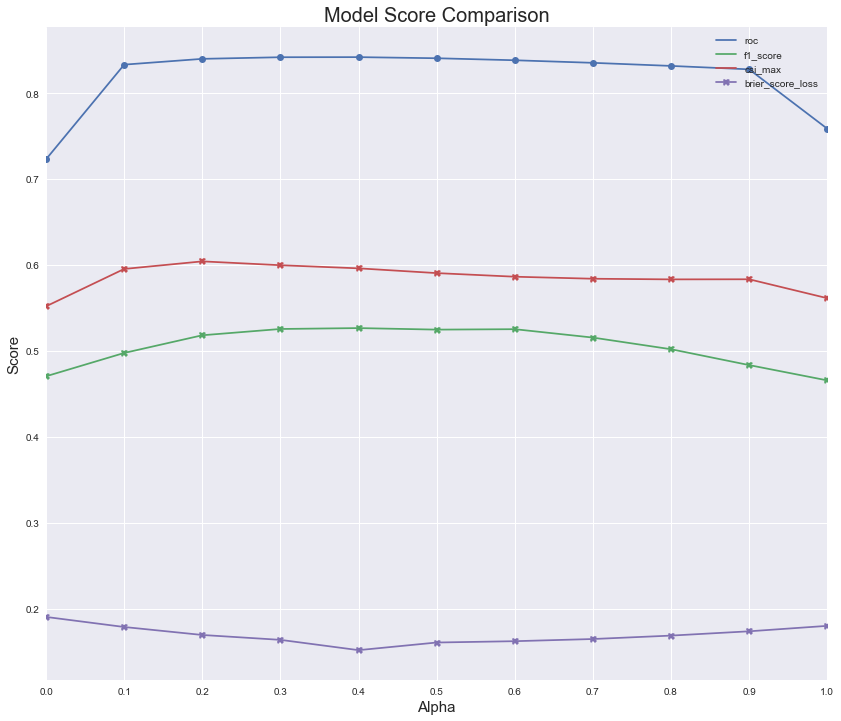

In [21]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot()
ax = alpha_score_df.plot(x='alpha', y='roc', ax=ax, marker='o')
ax = alpha_score_df.plot(x='alpha', y='f1_score', ax=ax, marker='X')
ax = alpha_score_df.plot(x='alpha', y='csi_max', ax=ax, marker='X')
ax = alpha_score_df.plot(x='alpha', y='brier_score_loss', ax=ax, marker='X')
_ = ax.set_xlabel('Alpha', fontsize=15)
_ = ax.set_ylabel('Score', fontsize=15)
_ = ax.set_title('Model Score Comparison', fontsize=20)
_ = ax.xaxis.set_ticks(np.linspace(0, 1.0, 11))

It's great to see that by combining the hotspot data from both geostationary and polar-orbiting satellites, the skill score actually improves ! 

Looking at the scores across different metrics, we can say that the best $\alpha$ is around 0.5-0.7. The values converge around this range. We'll pick $\alpha$ = 0.6. This means that the model slightly favours the contribution of hotspot detection by polar-orbiting satellite, which is usually the case in operational environment since polar-orbiting satellites have got a proven track record in fire detection.

### Model Selection 

In [22]:
best_alpha = 0.6
best_alpha_pipe = eval(alpha_score_df.loc[np.isclose(alpha_score_df['alpha'], best_alpha), 'best_estimator'].values[0])
best_alpha_pipe.set_params(**eval(alpha_score_df.loc[np.isclose(alpha_score_df['alpha'], best_alpha), 'params'].values[0]))


train_best_alpha_weight = ((1 - best_alpha) * training_balanced_df['geo_weight']) + (best_alpha * training_balanced_df['polar_weight']) 
test_best_alpha_weight = ((1 - best_alpha) * test_df['geo_weight']) + (best_alpha * test_df['polar_weight']) 

train_best_alpha_weight = train_best_alpha_weight.values.astype(float).reshape(-1, 1)
test_best_alpha_weight = test_best_alpha_weight.values.astype(float).reshape(-1, 1)

best_alpha_pipe.fit(train_best_alpha_weight, training_balanced_df['truth_flag'])
y_test_proba = best_alpha_pipe.predict_proba(test_best_alpha_weight)[:, 1]

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


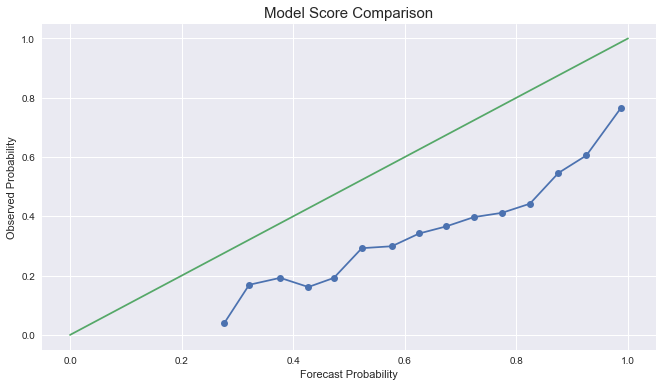

In [23]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_df['truth_flag'], y_test_proba, n_bins=20)
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot()
ax.plot(prob_pred, prob_true, marker='o')
ax.plot([0, 1], [0, 1])
ax.set_xlabel('Forecast Probability')
ax.set_ylabel('Observed Probability')
_ = ax.set_title('Model Score Comparison', {'fontsize': 15})

It's clear that the model forecast probability is overestimated, and we cannot use 0.5 as the cut-off threshold.

In [24]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer


def plot_learning_curve(estimator, title, X, y, ax=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ax : axis

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores, = \
    learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                   train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax.legend(loc="best")

    return plt

<module 'matplotlib.pyplot' from 'C:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

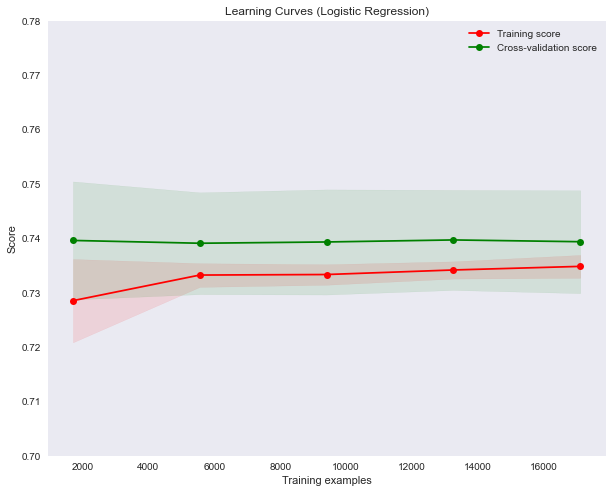

In [25]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

best_alpha = 0.6
lc_pipe = eval(alpha_score_df.loc[np.isclose(alpha_score_df['alpha'], best_alpha), 'best_estimator'].values[0])
lc_pipe.set_params(**eval(alpha_score_df.loc[np.isclose(alpha_score_df['alpha'], best_alpha), 'params'].values[0]))

train_best_alpha_weight = ((1 - best_alpha) * training_balanced_df['geo_weight']) + (best_alpha * training_balanced_df['polar_weight']) 

train_best_alpha_weight = train_best_alpha_weight.values.astype(float).reshape(-1, 1)

plot_learning_curve(lc_pipe, title, train_best_alpha_weight, training_balanced_df['truth_flag'], ax=ax, ylim=(0.7, 0.78),
                    cv=cv, n_jobs=4)

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true = test_df['truth_flag'], y_score = y_test_proba)
csi = 1/((1/(1-fpr)) + (1/tpr) - 1)
roc = roc_auc_score(y_true = test_df['truth_flag'], y_score = y_test_proba)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


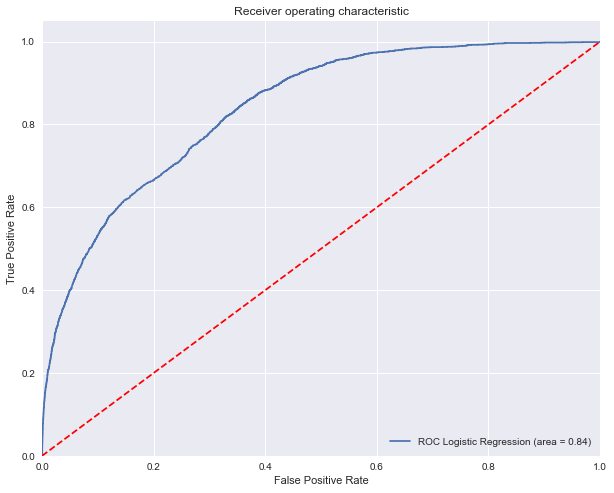

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.plot(fpr, tpr, label='ROC Logistic Regression (area = %0.2f)' % roc)
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if sys.path[0] == '':


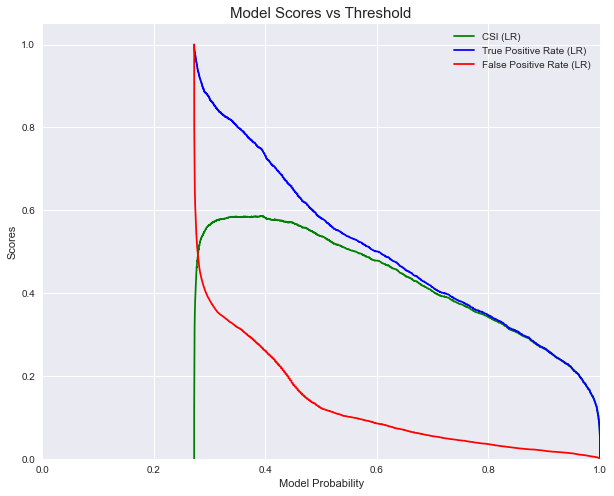

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
plt.plot(thresholds, csi, 'g', label='CSI (LR)')
plt.plot(thresholds, tpr, 'b', label='True Positive Rate (LR)')
plt.plot(thresholds, fpr, 'r', label='False Positive Rate (LR)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Model Probability')
ax.set_ylabel('Scores')
ax.set_title('Model Scores vs Threshold', fontsize=15)
_ = ax.legend(loc="top right")

## Method 2: No Feature Engineering

Instead of creating a new feature, we will attempt to see if machine learning model can outperform **Method 1** by using the original features.

In [29]:
model_eval = {}
model_eval_df = pd.DataFrame()

for model in model_param_json.keys():
        
    clf_pipeline = Pipeline([('clf', model_param_json[model]['clf'])])

    gs_clf = GridSearchCV(estimator=clf_pipeline, 
                           param_grid=model_param_json[model]['param_grid'], 
                           scoring='roc_auc', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=3, 
                           refit=True,
                           pre_dispatch='2*n_jobs')
    
    gs_clf.fit(training_balanced_df[predict_features], training_balanced_df['truth_flag'])

    print (f'Best estimator : {gs_clf.best_estimator_}')
    print (f'Best params : {gs_clf.best_params_}')
    
    model_eval['best_estimator'] = gs_clf.best_estimator_
    model_eval['params'] = gs_clf.best_params_
    
    y_prob = gs_clf.predict_proba(test_df[predict_features])[:,1]   
    y_pred = gs_clf.predict(test_df[predict_features])
    
    fpr, tpr, thresholds = roc_curve(test_df['truth_flag'], y_prob)
    csi = 1/((1/(1-fpr)) + (1/tpr) - 1)

    model_eval['roc'] = roc_auc_score(y_true=test_df['truth_flag'], y_score=y_prob)
    model_eval['brier_score_loss'] = brier_score_loss(y_true=test_df['truth_flag'], y_prob=y_prob)
    model_eval['f1_score'] = f1_score(y_true=test_df['truth_flag'], y_pred=y_pred)
    model_eval['csi_max'] = csi.max()
    model_eval['tpr'] = tpr[csi.argmax()]
    model_eval['fpr'] = fpr[csi.argmax()]
    model_eval['threshold'] = thresholds[csi.argmax()]
    
    model_eval_df = model_eval_df.append(model_eval, ignore_index=True)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed:    0.4s remaining:    0.4s


Best estimator : Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=2.5, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='none', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Best params : {'clf__C': 2.5, 'clf__fit_intercept': True, 'clf__penalty': 'none', 'clf__solver': 'saga'}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [30]:
model_eval_df

,best_estimator,brier_score_loss,csi_max,f1_score,fpr,params,roc,threshold,tpr
0,"(LogisticRegression(C=2.5, class_weight=None, ...",0.160859,0.590807,0.523699,0.275683,"{'clf__C': 2.5, 'clf__fit_intercept': True, 'c...",0.840302,0.385478,0.762202


### Model Selection 

In [31]:
best_pipe = eval(str(model_eval_df.loc[0, 'best_estimator']))
best_pipe.set_params(**eval(str(model_eval_df.loc[0, 'params'])))

best_pipe.fit(training_balanced_df[predict_features], training_balanced_df['truth_flag'])
y_test_m2_proba = best_pipe.predict_proba(test_df[predict_features])[:, 1]

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


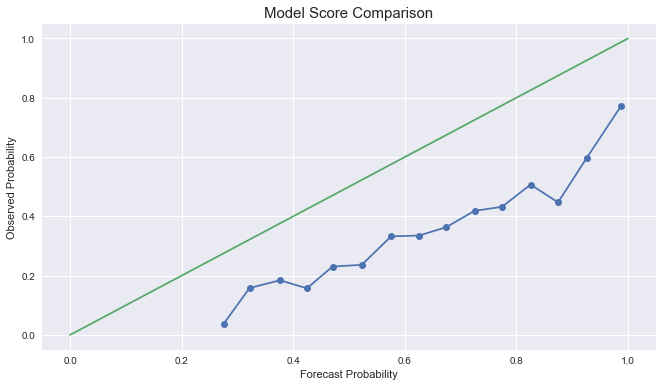

In [32]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_df['truth_flag'], y_test_m2_proba, n_bins=20)
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot()
ax.plot(prob_pred, prob_true, marker='o')
ax.plot([0, 1], [0, 1])
ax.set_xlabel('Forecast Probability')
ax.set_ylabel('Observed Probability')
_ = ax.set_title('Model Score Comparison', {'fontsize': 15})

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true = test_df['truth_flag'], y_score = y_test_m2_proba)
csi = 1/((1/(1-fpr)) + (1/tpr) - 1)
roc = roc_auc_score(y_true = test_df['truth_flag'], y_score = y_test_m2_proba)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


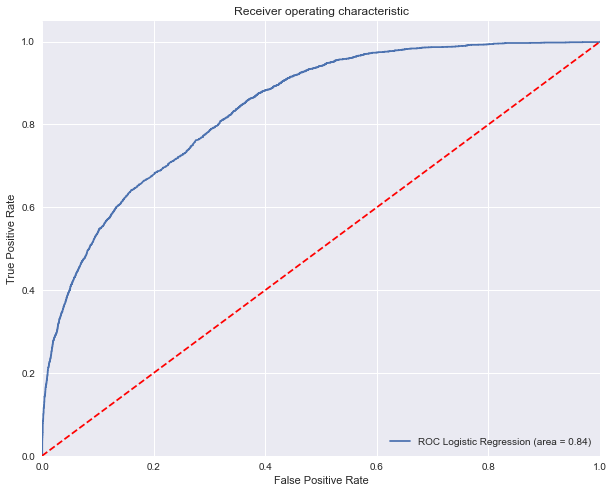

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.plot(fpr, tpr, label='ROC Logistic Regression (area = %0.2f)' % roc)
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")

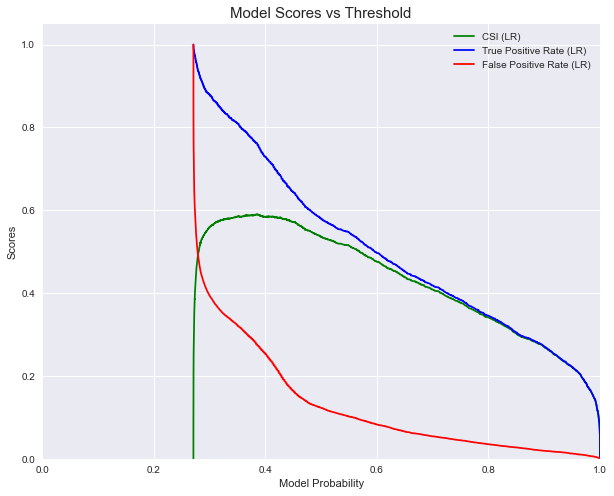

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
plt.plot(thresholds, csi, 'g', label='CSI (LR)')
plt.plot(thresholds, tpr, 'b', label='True Positive Rate (LR)')
plt.plot(thresholds, fpr, 'r', label='False Positive Rate (LR)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Model Probability')
ax.set_ylabel('Scores')
ax.set_title('Model Scores vs Threshold', fontsize=15)
_ = ax.legend(loc="upper right")

## Assessing Model Performance with Missed Detections

In [36]:
filter_na = predict_gdf['polar_weight'].isna()

In [39]:
len(predict_gdf.loc[filter_na])/len(predict_gdf.loc[predict_gdf['truth_flag'] == 1])

0.3095372896186114

In [41]:
predict_gdf['model_prob'] = 0

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
predict_gdf.loc[~filter_na, 'weight'] = ((1 - best_alpha) * predict_gdf.loc[~filter_na, 'geo_weight']) + (best_alpha * predict_gdf.loc[~filter_na, 'polar_weight']) 

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [53]:
non_na_weights = predict_gdf.loc[~filter_na, 'weight'].values.astype(float).reshape(-1, 1)

In [57]:
predict_gdf.loc[~filter_na, 'model_prob'] = best_alpha_pipe.predict_proba(non_na_weights)[:, 1]

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true = predict_gdf['truth_flag'], y_score = predict_gdf['model_prob'])
csi = 1/((1/(1-fpr)) + (1/tpr) - 1)
roc = roc_auc_score(y_true = predict_gdf['truth_flag'], y_score = predict_gdf['model_prob'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


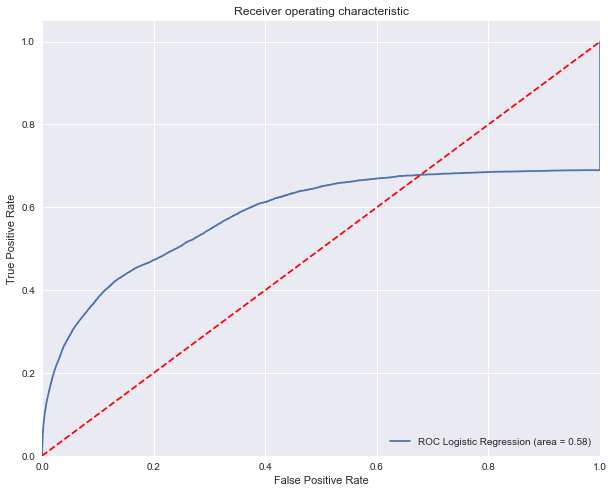

In [59]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.plot(fpr, tpr, label='ROC Logistic Regression (area = %0.2f)' % roc)
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")

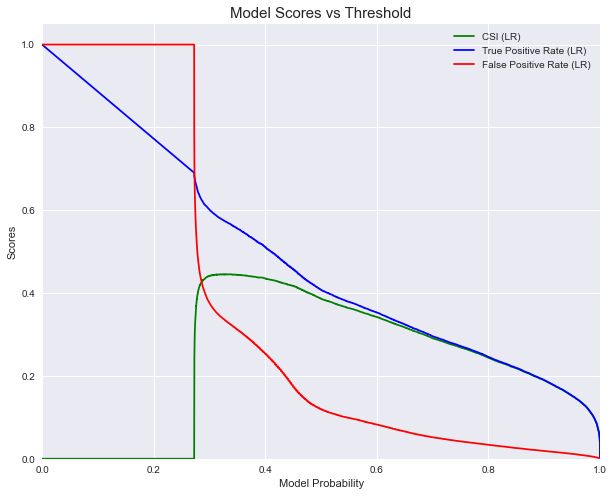

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
plt.plot(thresholds, csi, 'g', label='CSI (LR)')
plt.plot(thresholds, tpr, 'b', label='True Positive Rate (LR)')
plt.plot(thresholds, fpr, 'r', label='False Positive Rate (LR)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Model Probability')
ax.set_ylabel('Scores')
ax.set_title('Model Scores vs Threshold', fontsize=15)
_ = ax.legend(loc="upper right")